In [154]:
import pandas as pd 
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import datetime as dt

In [136]:
spy = pdr.YahooOptions('SPY')  

In [137]:
spy.headers = {'User-Agent': 'Firefox'}

In [138]:
allopt = spy.get_all_data()
allopt.reset_index(inplace = True)

In [148]:
exp1 = allopt[allopt.Expiry == "2022-10-05"] #spy.expiry_dates[1]

calls = exp1[exp1.Type=='call']
calls['C'] = (calls.Bid+calls.Ask)/2
puts = exp1[exp1.Type=='put']
puts['P'] = (puts.Bid+puts.Ask)/2

<ipython-input-148-a634b4f721d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['C'] = (calls.Bid+calls.Ask)/2
<ipython-input-148-a634b4f721d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puts['P'] = (puts.Bid+puts.Ask)/2


In [149]:
df = pd.merge(calls, puts, how='inner', on ='Strike')

### Lets test the Put/Call Parity

$$C + K e^{-rT} = P + S_0$$

This equation implies the NAC condition (for puts and calls with the same strike price).  Parity: $P = C + K e^{-rT} - S_0$

We can also derive the timesensitive interest rate, $r = -\frac{ln |\frac{P + S_0 - C}{K}|}{T}$

In [151]:
df["Parity"] = df.C + df.Strike - df.Underlying_Price_x

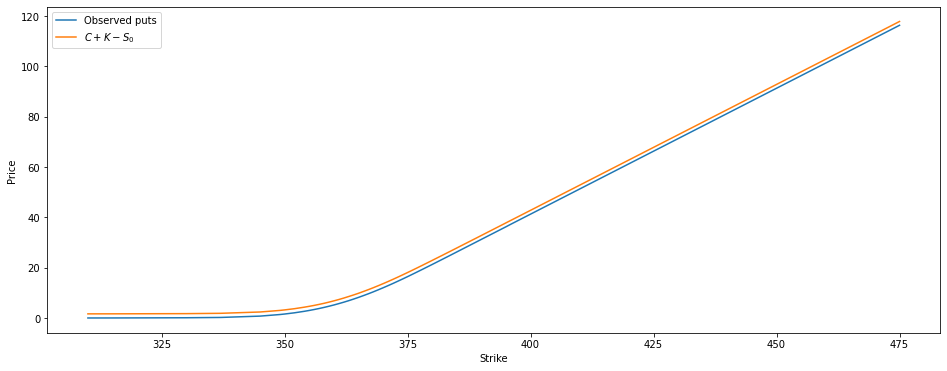

In [166]:
plt.figure(figsize = (16, 6))
plt.plot(df.Strike, df.P, label = "Observed puts")
plt.plot(df.Strike, df.Parity, label = r"$C + K - S_0$")
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend()

### Deriving the overtime interest rate. 

$$r = -\frac{ln |\frac{P + S_0 - C}{K}|}{T}$$

In [155]:
df["Time"] = (df.Expiry_x - dt.datetime.now()).dt.days / 255
df["r"] = - np.log((df.P + df.Underlying_Price_x)/df.Strike)/df.Time

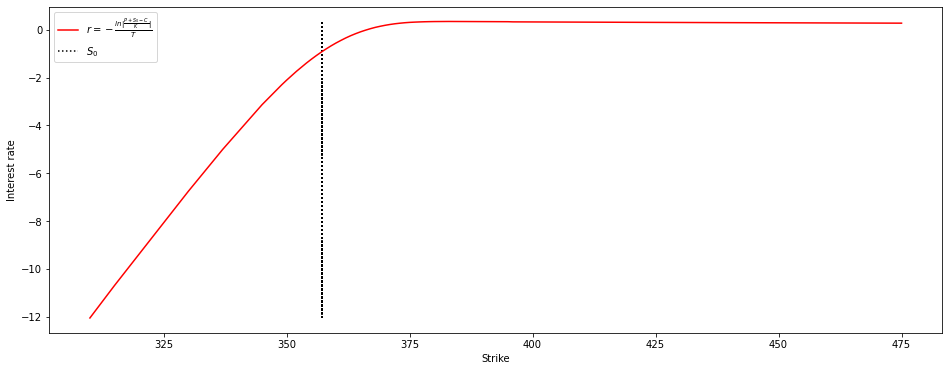

In [177]:
plt.figure(figsize = (16, 6))
plt.plot(df.Strike, df.r, label = r"$r = -\frac{ln |\frac{P + S_0 - C}{K}|}{T}$", color = "red")
plt.xlabel("Strike")
plt.ylabel("Interest rate")
plt.vlines(df.Underlying_Price_x, df.r.min(), df.r.max(), linestyle = "dotted", label = r"$S_0$", color = 'black')
plt.legend()

### PLotting the parity with respect to interest rate. 
 $P = C + K e^{-rT} - S_0$

In [167]:
df["Parity_i"] = df.C + df.Strike * np.exp(-df.r * df.Time) - df.Underlying_Price_x

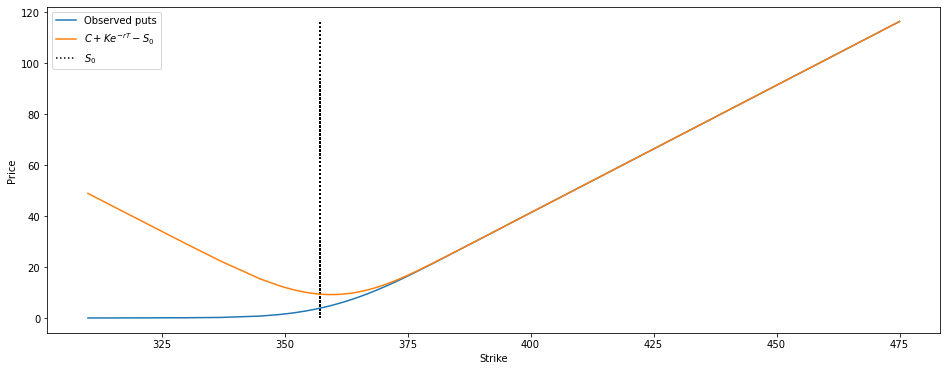

In [176]:
plt.figure(figsize = (16, 6))
plt.plot(df.Strike, df.P, label = "Observed puts")
plt.plot(df.Strike, df.Parity_i, label = r"$C + Ke^{-rT} - S_0$")
plt.xlabel('Strike')
plt.ylabel('Price')
plt.vlines(df.Underlying_Price_x, df.P.min(), df.P.max(), linestyle = "dotted", label = r"$S_0$", color = 'black')
plt.legend()